In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers
from keras.layers import Dense, Dropout, LSTM
from keras.utils import to_categorical
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

Using TensorFlow backend.


### Load data

In [2]:
train = pd.read_csv('../input/X_train.csv')
labels = pd.read_csv('../input/y_train.csv')
test = pd.read_csv('../input/X_test.csv').sort_values(['series_id', 'measurement_number'])

### Join train features with labels

In [3]:
train = pd.merge(train, labels, how='inner').sort_values(['series_id', 'measurement_number'])
print(train.shape)
display(train.head())
display(train.describe().T)

(487680, 15)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


,count,mean,std,min,25%,50%,75%,max
series_id,487680.0,1904.500000,1099.853353,0.00000,952.000000,1904.500000,2857.000000,3809.00000
measurement_number,487680.0,63.500000,36.949327,0.00000,31.750000,63.500000,95.250000,127.00000
orientation_X,487680.0,-0.018050,0.685696,-0.98910,-0.705120,-0.105960,0.651803,0.98910
orientation_Y,487680.0,0.075062,0.708226,-0.98965,-0.688980,0.237855,0.809550,0.98898
orientation_Z,487680.0,0.012458,0.105972,-0.16283,-0.089466,0.031949,0.122870,0.15571
orientation_W,487680.0,-0.003804,0.104299,-0.15662,-0.106060,-0.018704,0.097215,0.15477
angular_velocity_X,487680.0,0.000178,0.117764,-2.37100,-0.040752,0.000084,0.040527,2.28220
angular_velocity_Y,487680.0,0.008338,0.088677,-0.92786,-0.033191,0.005412,0.048068,1.07910
angular_velocity_Z,487680.0,-0.019184,0.229153,-1.26880,-0.090743,-0.005335,0.064604,1.38730
linear_acceleration_X,487680.0,0.129281,1.870600,-36.06700,-0.530833,0.124980,0.792263,36.79700


### Feature engineering

In [4]:
def feat_eng(df):
    df['totl_anglr_vel'] = (df['angular_velocity_X']**2 + df['angular_velocity_Y']**2 + df['angular_velocity_Z'])** 0.5
    df['totl_linr_acc'] = (df['linear_acceleration_X']**2 + df['linear_acceleration_Y']**2 + df['linear_acceleration_Z'])**0.5
    df['totl_xyz'] = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z'])**0.5
    df['acc_vs_vel'] = df['totl_linr_acc'] / df['totl_anglr_vel']

feat_eng(train)
feat_eng(test)

train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

### Turn data into series

In [5]:
def series_to_supervised(data, features, window=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data[features].shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in features]
    # Current timestep (t=0)
    cols.append(data)
    names += [(col) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [6]:
window = 5
features = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 
            'totl_anglr_vel', 'totl_linr_acc', 'totl_xyz', 'acc_vs_vel' ,
            'series_id']
use_cols = features + ['surface']
# Train
train_series = series_to_supervised(train[use_cols], features, window=window)
train_series.dropna(inplace=True)        
train_series = train_series[(train_series['series_id'] == train_series['series_id(t-%s)' % window])]
display(train_series.head())

# Test
test_series = series_to_supervised(test[features], features, window=window)
test_series.fillna(test_series.mean(), inplace=True)

# Backwards inputation
for index, row in test_series.iterrows():
    for i in range(1, window+1):
        if row['series_id'] != row['series_id(t-%s)' % i]:
            for feature in features:
                if feature != 'series_id':
                    test_series.at[index, '%s(t-%s)' % (feature, i)] = row[feature]
display(test_series.head())

,angular_velocity_X(t-5),angular_velocity_Y(t-5),angular_velocity_Z(t-5),linear_acceleration_X(t-5),linear_acceleration_Y(t-5),linear_acceleration_Z(t-5),totl_anglr_vel(t-5),totl_linr_acc(t-5),totl_xyz(t-5),acc_vs_vel(t-5),series_id(t-5),angular_velocity_X(t-4),angular_velocity_Y(t-4),angular_velocity_Z(t-4),linear_acceleration_X(t-4),linear_acceleration_Y(t-4),linear_acceleration_Z(t-4),totl_anglr_vel(t-4),totl_linr_acc(t-4),totl_xyz(t-4),acc_vs_vel(t-4),series_id(t-4),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),totl_anglr_vel(t-3),totl_linr_acc(t-3),totl_xyz(t-3),acc_vs_vel(t-3),series_id(t-3),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),totl_anglr_vel(t-2),totl_linr_acc(t-2),totl_xyz(t-2),acc_vs_vel(t-2),series_id(t-2),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),totl_anglr_vel(t-1),totl_linr_acc(t-1),totl_xyz(t-1),acc_vs_vel(t-1),series_id(t-1),angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,totl_anglr_vel,totl_linr_acc,totl_xyz,acc_vs_vel,series_id,surface
5,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.112536,0.0,0.934285,0.0,0.0,0.067851,0.029939,0.003385,0.33995,1.50640,-9.4128,0.094263,0.0,0.934267,0.0,0.0,0.007275,0.028934,-0.005978,-0.26429,1.59220,-8.7267,0.000000,0.0,0.934263,0.0,0.0,-0.013053,0.019448,-0.008974,0.42684,1.099300,-10.0960,0.000000,0.0,0.934246,0.0,0.0,0.005135,0.007652,0.005245,-0.50969,1.468900,-10.4410,0.073008,0.0,0.934239,0.0,0.0,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,0.000000,0.0,0.934339,0.0,0,fine_concrete
6,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.094263,0.0,0.934267,0.0,0.0,0.007275,0.028934,-0.005978,-0.26429,1.59220,-8.7267,0.000000,0.0,0.934263,0.0,0.0,-0.013053,0.019448,-0.008974,0.42684,1.09930,-10.0960,0.000000,0.0,0.934246,0.0,0.0,0.005135,0.007652,0.005245,-0.50969,1.468900,-10.4410,0.073008,0.0,0.934239,0.0,0.0,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,0.000000,0.0,0.934339,0.0,0.0,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296,0.077581,0.0,0.934363,0.0,0,fine_concrete
7,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,0.000000,0.0,0.934263,0.0,0.0,-0.013053,0.019448,-0.008974,0.42684,1.09930,-10.0960,0.000000,0.0,0.934246,0.0,0.0,0.005135,0.007652,0.005245,-0.50969,1.46890,-10.4410,0.073008,0.0,0.934239,0.0,0.0,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,0.000000,0.0,0.934339,0.0,0.0,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296,0.077581,0.0,0.934363,0.0,0.0,0.056218,0.038162,-0.022931,-0.12160,0.075417,-8.6088,0.000000,0.0,0.934380,0.0,0,fine_concrete
8,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,0.000000,0.0,0.934246,0.0,0.0,0.005135,0.007652,0.005245,-0.50969,1.46890,-10.4410,0.073008,0.0,0.934239,0.0,0.0,0.059664,0.013043,-0.013231,-0.44745,0.99281,-10.4020,0.000000,0.0,0.934339,0.0,0.0,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296,0.077581,0.0,0.934363,0.0,0.0,0.056218,0.038162,-0.022931,-0.12160,0.075417,-8.6088,0.000000,0.0,0.934380,0.0,0.0,-0.012846,0.039004,-0.007831,1.60000,0.816110,-7.6426,0.000000,0.0,0.934352,0.0,0,fine_concrete
9,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.073008,0.0,0.934239,0.0,0.0,0.059664,0.013043,-0.013231,-0.44745,0.99281,-10.4020,0.000000,0.0,0.934339,0.0,0.0,0.082140,0.044356,-0.002696,-0.14163,0.73497,-9.4296,0.077581,0.0,0.934363,0.0,0.0,0.056218,0.038162,-0.022931,-0.12160,0.075417,-8.6088,0.000000,0.0,0.934380,0.0,0.0,-0.012846,0.039004,-0.007831,1.60000,0.816110,-7.6426,0.000000,0.0,0.934352,0.0,0.0,-0.090082,0.027299,-0.009970,0.47496,0.909600,-8.8120,0.000000,0.0,0.934317,0.0,0,fine_concrete


,angular_velocity_X(t-5),angular_velocity_Y(t-5),angular_velocity_Z(t-5),linear_acceleration_X(t-5),linear_acceleration_Y(t-5),linear_acceleration_Z(t-5),totl_anglr_vel(t-5),totl_linr_acc(t-5),totl_xyz(t-5),acc_vs_vel(t-5),series_id(t-5),angular_velocity_X(t-4),angular_velocity_Y(t-4),angular_velocity_Z(t-4),linear_acceleration_X(t-4),linear_acceleration_Y(t-4),linear_acceleration_Z(t-4),totl_anglr_vel(t-4),totl_linr_acc(t-4),totl_xyz(t-4),acc_vs_vel(t-4),series_id(t-4),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),totl_anglr_vel(t-3),totl_linr_acc(t-3),totl_xyz(t-3),acc_vs_vel(t-3),series_id(t-3),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),totl_anglr_vel(t-2),totl_linr_acc(t-2),totl_xyz(t-2),acc_vs_vel(t-2),series_id(t-2),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),totl_anglr_vel(t-1),totl_linr_acc(t-1),totl_xyz(t-1),acc_vs_vel(t-1),series_id(t-1),angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,totl_anglr_vel,totl_linr_acc,totl_xyz,acc_vs_vel,series_id
0,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.00000,3.486755,0.911078,0.000000,1907.480474,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.0,3.486755,0.911078,0.0,1907.484379,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.0,3.486755,0.911078,0.0,1907.488284,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.0,3.486755,0.911078,0.0,1907.49219,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.0,3.486755,0.911078,0.0,1907.496095,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.00000,3.486755,0.911078,0.000000,0
1,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.00000,2.898157,0.910972,0.000000,1907.480474,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.0,2.898157,0.910972,0.0,1907.484379,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.0,2.898157,0.910972,0.0,1907.488284,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.0,2.898157,0.910972,0.0,1907.49219,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.0,3.486755,0.911078,0.0,0.000000,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.00000,2.898157,0.910972,0.000000,0
2,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,0.00000,0.000000,0.910904,0.000000,1907.480474,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,0.0,0.000000,0.910904,0.0,1907.484379,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,0.0,0.000000,0.910904,0.0,1907.488284,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.0,3.486755,0.911078,0.0,0.00000,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.0,2.898157,0.910972,0.0,0.000000,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,0.00000,0.000000,0.910904,0.000000,0
3,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,0.00000,0.000000,0.910963,0.000000,1907.480474,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,0.0,0.000000,0.910963,0.0,1907.484379,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.0,3.486755,0.911078,0.0,0.000000,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.0,2.898157,0.910972,0.0,0.00000,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,0.0,0.000000,0.910904,0.0,0.000000,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,0.00000,0.000000,0.910963,0.000000,0
4,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100,0.09299,2.986768,0.911143,32.119254,1907.480474,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.0,3.486755,0.911078,0.0,0.000000,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.0,2.898157,0.910972,0.0,0.000000,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,0.0,0.000000,0.910904,0.0,0.00000,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,0.0,0.000000,0.

### Pre process the labels

In [7]:
n_labels =  train_series['surface'].nunique()
labels_names = train_series['surface'].unique()
le = LabelEncoder()
train_series['surface'] = le.fit_transform(train_series['surface'].values)

### Train/validation split

In [8]:
train_splited = []
val_splited = []
gp_surface = train.groupby(['surface', 'series_id'], as_index=False).count()[['surface', 'series_id']]
for surface in gp_surface['surface'].unique():
    df = gp_surface[gp_surface['surface'] == surface]
    tra, val = train_test_split(df, test_size=0.2, random_state=0)
    train_splited += list(tra['series_id'].values)
    val_splited += list(val['series_id'].values)
    
train_splited = pd.DataFrame(train_splited, columns=['series_id'])
val_splited = pd.DataFrame(val_splited, columns=['series_id'])

In [9]:
X_train = train_splited.merge(train_series)
X_val = val_splited.merge(train_series)

Y_train = X_train['surface']
Y_train = to_categorical(Y_train)
X_train.drop('surface', axis=1, inplace=True)
X_train = X_train

Y_val = X_val['surface']
Y_val = to_categorical(Y_val)
X_val.drop('surface', axis=1, inplace=True)
X_val = X_val

series_cols = list(X_train.filter(regex='series_id'))
X_train.drop(series_cols, axis=1, inplace=True)
X_val.drop(series_cols, axis=1, inplace=True)
test_series.drop(series_cols, axis=1, inplace=True)

print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.head())

Train shape (374412, 60)
Validation shape (94218, 60)


,angular_velocity_X(t-5),angular_velocity_Y(t-5),angular_velocity_Z(t-5),linear_acceleration_X(t-5),linear_acceleration_Y(t-5),linear_acceleration_Z(t-5),totl_anglr_vel(t-5),totl_linr_acc(t-5),totl_xyz(t-5),acc_vs_vel(t-5),angular_velocity_X(t-4),angular_velocity_Y(t-4),angular_velocity_Z(t-4),linear_acceleration_X(t-4),linear_acceleration_Y(t-4),linear_acceleration_Z(t-4),totl_anglr_vel(t-4),totl_linr_acc(t-4),totl_xyz(t-4),acc_vs_vel(t-4),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),totl_anglr_vel(t-3),totl_linr_acc(t-3),totl_xyz(t-3),acc_vs_vel(t-3),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),totl_anglr_vel(t-2),totl_linr_acc(t-2),totl_xyz(t-2),acc_vs_vel(t-2),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),totl_anglr_vel(t-1),totl_linr_acc(t-1),totl_xyz(t-1),acc_vs_vel(t-1),angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,totl_anglr_vel,totl_linr_acc,totl_xyz,acc_vs_vel
0,0.028959,-0.011703,0.026238,0.032400,4.1378,-8.8985,0.164965,2.867741,0.993417,17.383894,0.014238,-0.015342,0.030203,0.422020,3.7190,-9.1178,0.175046,2.211620,0.993427,12.634507,0.017162,-0.026594,0.038941,0.074069,3.3176,-9.4564,0.199857,1.247219,0.993444,6.240562,0.035360,-0.032865,0.037684,0.16020,3.9802,-9.1033,0.200036,2.600838,0.993465,13.001842,0.028209,-0.006577,0.039904,0.09113,3.9570,-9.1022,0.201849,2.562021,0.993469,12.692764,0.023578,-0.013967,0.033559,-0.42657,4.0422,-9.0786,0.185230,2.728139,0.993485,14.728420
1,0.014238,-0.015342,0.030203,0.422020,3.7190,-9.1178,0.175046,2.211620,0.993427,12.634507,0.017162,-0.026594,0.038941,0.074069,3.3176,-9.4564,0.199857,1.247219,0.993444,6.240562,0.035360,-0.032865,0.037684,0.160200,3.9802,-9.1033,0.200036,2.600838,0.993465,13.001842,0.028209,-0.006577,0.039904,0.09113,3.9570,-9.1022,0.201849,2.562021,0.993469,12.692764,0.023578,-0.013967,0.033559,-0.42657,4.0422,-9.0786,0.185230,2.728139,0.993485,14.728420,0.034825,-0.020897,0.042671,0.13972,3.6555,-9.5355,0.210524,1.961301,0.993498,9.316271
2,0.017162,-0.026594,0.038941,0.074069,3.3176,-9.4564,0.199857,1.247219,0.993444,6.240562,0.035360,-0.032865,0.037684,0.160200,3.9802,-9.1033,0.200036,2.600838,0.993465,13.001842,0.028209,-0.006577,0.039904,0.091130,3.9570,-9.1022,0.201849,2.562021,0.993469,12.692764,0.023578,-0.013967,0.033559,-0.42657,4.0422,-9.0786,0.185230,2.728139,0.993485,14.728420,0.034825,-0.020897,0.042671,0.13972,3.6555,-9.5355,0.210524,1.961301,0.993498,9.316271,0.060540,-0.014815,0.045493,-0.53125,3.1171,-9.6271,0.222211,0.609458,0.993506,2.742703
3,0.035360,-0.032865,0.037684,0.160200,3.9802,-9.1033,0.200036,2.600838,0.993465,13.001842,0.028209,-0.006577,0.039904,0.091130,3.9570,-9.1022,0.201849,2.562021,0.993469,12.692764,0.023578,-0.013967,0.033559,-0.426570,4.0422,-9.0786,0.185230,2.728139,0.993485,14.728420,0.034825,-0.020897,0.042671,0.13972,3.6555,-9.5355,0.210524,1.961301,0.993498,9.316271,0.060540,-0.014815,0.045493,-0.53125,3.1171,-9.6271,0.222211,0.609458,0.993506,2.742703,0.065362,-0.005506,0.040376,0.14338,3.3331,-9.2001,0.211373,1.389249,0.993516,6.572504
4,0.028209,-0.006577,0.039904,0.091130,3.9570,-9.1022,0.201849,2.562021,0.993469,12.692764,0.023578,-0.013967,0.033559,-0.426570,4.0422,-9.0786,0.185230,2.728139,0.993485,14.728420,0.034825,-0.020897,0.042671,0.139720,3.6555,-9.5355,0.210524,1.961301,0.993498,9.316271,0.060540,-0.014815,0.045493,-0.53125,3.1171,-9.6271,0.222211,0.609458,0.993506,2.742703,0.065362,-0.005506,0.040376,0.14338,3.3331,-9.2001,0.211373,1.389249,0.993516,6.572504,0.050770,-0.008735,0.042182,-0.25085,3.4112,-8.6230,0.211745,1.753913,0.993529,8.283143


### Feature engineering

In [10]:
features = list(X_train.columns)
print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.describe().T)

Train shape (374412, 60)
Validation shape (94218, 60)


,count,mean,std,min,25%,50%,75%,max
angular_velocity_X(t-5),374412.0,0.000262,0.116795,-2.37100,-0.040808,0.000086,0.040638,2.282200
angular_velocity_Y(t-5),374412.0,0.008466,0.088008,-0.92786,-0.033414,0.005343,0.047913,1.079100
angular_velocity_Z(t-5),374412.0,-0.019526,0.226591,-1.26880,-0.090264,-0.005179,0.065480,1.387300
linear_acceleration_X(t-5),374412.0,0.128795,1.871716,-31.14200,-0.537065,0.123860,0.795427,36.797000
linear_acceleration_Y(t-5),374412.0,2.887226,2.105540,-82.75300,1.958300,2.878900,3.803000,55.948000
linear_acceleration_Z(t-5),374412.0,-9.365155,2.825914,-65.49200,-10.200000,-9.365900,-8.513100,65.839000
totl_anglr_vel(t-5),374412.0,0.166897,0.215444,0.00000,0.000000,0.053903,0.287612,2.354958
totl_linr_acc(t-5),374412.0,1.774088,2.451913,0.00000,0.000000,0.678269,2.979057,86.014069
totl_xyz(t-5),374412.0,0.994579,0.053452,0.90101,0.944228,1.006819,1.050163,1.063410
acc_vs_vel(t-5),374412.0,4.455608,16.982484,0.00000,0.000000,0.000000,2.849962,2644.116880


### Scale the data

In [11]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_series)

In [12]:
X_val_series = X_val.reshape(X_val.shape[0], (window+1), (X_val.shape[1] // (window+1)))
print('Validation set shape', X_val_series.shape)

Validation set shape (94218, 6, 10)


In [13]:
X_train_series = X_train.reshape(X_train.shape[0], (window+1), (X_train.shape[1] // (window+1)))
X_val_series = X_val.reshape(X_val.shape[0], (window+1), (X_val.shape[1] // (window+1)))
X_test_series = X_test.reshape(X_test.shape[0], (window+1), (X_test.shape[1] // (window+1)))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_val_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (374412, 6, 10)
Validation set shape (94218, 6, 10)
Test set shape (488448, 6, 10)


### Model

In [14]:
epochs = 30
batch = 128
lr = 0.001
adam = optimizers.Adam(lr)

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
model = Sequential()
model.add(LSTM(16, activation='relu', return_sequences=True, input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model.add(LSTM(8, activation='relu'))
model.add(Dense(n_labels, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=adam)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 16)             1728      
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 81        
Total params: 2,609
Trainable params: 2,609
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(X_train_series, Y_train, validation_data=(X_val_series, Y_val), epochs=epochs, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 374412 samples, validate on 94218 samples
Epoch 1/30
 - 237s - loss: 1.5510 - val_loss: 1.3903
Epoch 2/30
 - 234s - loss: 1.3483 - val_loss: 1.3460
Epoch 3/30
 - 234s - loss: 1.2655 - val_loss: 1.2953
Epoch 4/30
 - 234s - loss: 1.1958 - val_loss: 1.2196
Epoch 5/30
 - 235s - loss: 1.1317 - val_loss: 1.2208
Epoch 6/30
 - 234s - loss: 1.0684 - val_loss: 1.0931
Epoch 7/30
 - 234s - loss: 1.0214 - val_loss: 1.0729
Epoch 8/30
 - 234s - loss: 0.9951 - val_loss: 1.0738
Epoch 9/30
 - 235s - loss: 0.9738 - val_loss: 1.0337
Epoch 10/30
 - 233s - loss: 0.9596 - val_loss: 1.0199
Epoch 11/30
 - 235s - loss: 0.9440 - val_loss: 1.0405
Epoch 12/30
 - 235s - loss: 0.9321 - val_loss: 1.0093
Epoch 13/30
 - 234s - loss: 0.9223 - val_loss: 0.9937
Epoch 14/30
 - 233s - loss: 0.9135 - val_loss: 0.9756
Epoch 15/30
 - 234s - loss: 0.9041 - val_loss: 1.0393
Epoch 16/30
 - 232s - loss: 0.8953 - val_loss: 0.9932
Epoch 17/30
 - 233s - loss: 0.8875 - val_loss:

#### Model loss plot

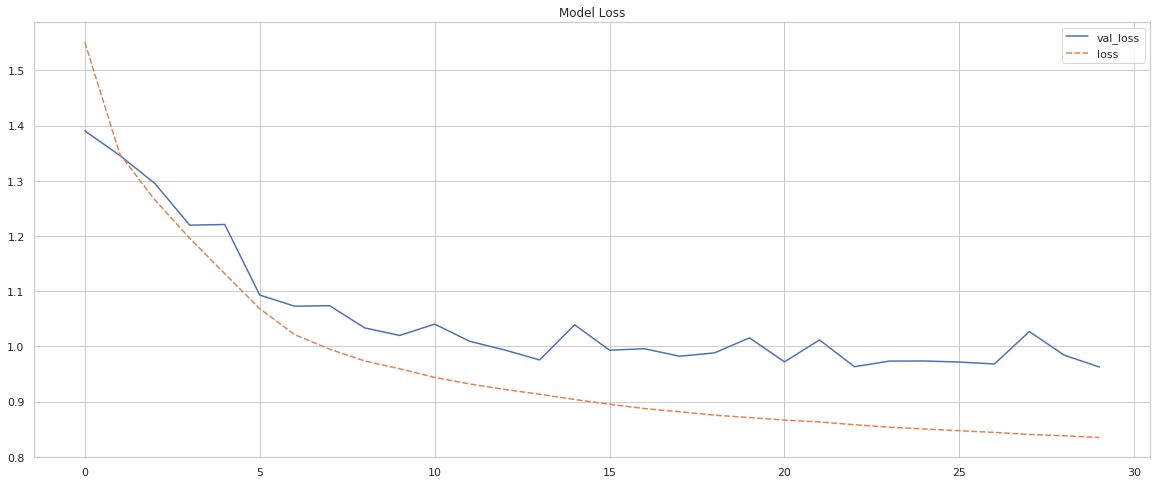

In [17]:
history_pd = pd.DataFrame.from_dict(history.history)
plt.figure(figsize=(20, 8))
ax = plt.axes()
ax.set_title('Model Loss')
sns.lineplot(data=history_pd)
plt.show()

#### Model evaluation

In [18]:
train_pred = model.predict_classes(X_train_series)
val_pred = model.predict_classes(X_val_series)
Y_train_max = np.argmax(Y_train, axis=1)
Y_val_max = np.argmax(Y_val, axis=1)

print('Train accuracy', accuracy_score(Y_train_max, train_pred))
print('Validation accuracy', accuracy_score(Y_val_max, val_pred))

Train accuracy 0.6918368001025608
Validation accuracy 0.6494618862637712


#### Model confusion matrix

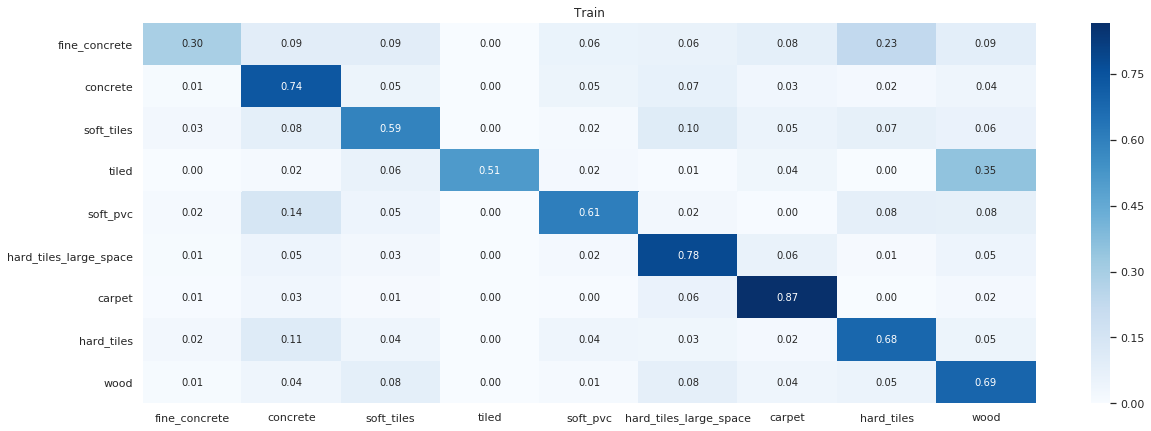

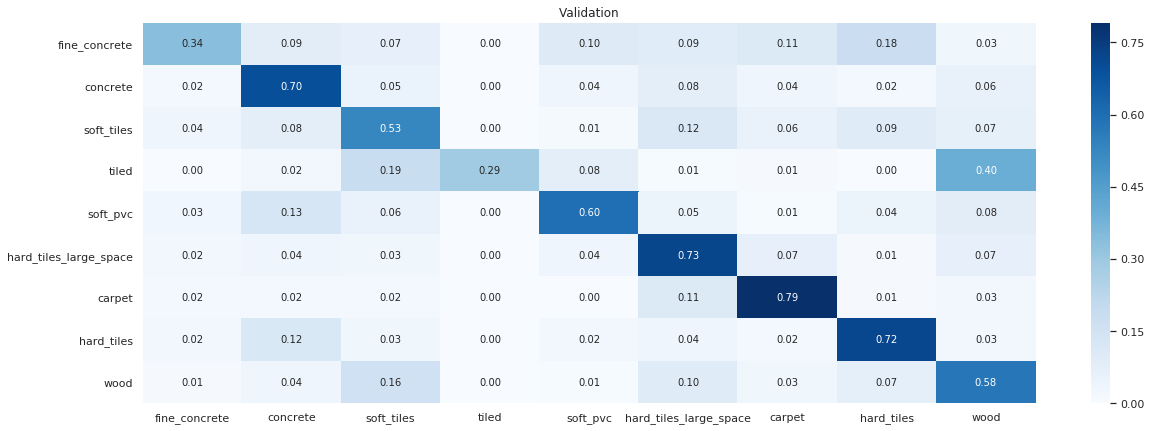

In [19]:
cnf_matrix = confusion_matrix(Y_train_max, train_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Train')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

cnf_matrix = confusion_matrix(Y_val_max, val_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Validation')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

### Test predictions

In [20]:
predictions = model.predict_classes(X_test_series)
test['surface'] = le.inverse_transform(predictions)
df = test[['series_id', 'surface']]
df = df.groupby('series_id', as_index=False).agg(lambda x:x.value_counts().index[0])
df.to_csv('submission.csv', index=False)
df.head(10)

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,soft_tiles
4,4,soft_pvc
5,5,concrete
6,6,concrete
7,7,hard_tiles_large_space
8,8,soft_tiles
9,9,soft_pvc
